In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
import numpy as np

from utils import load_dataframe, show_images
from tuberculosis_dataset import TuberculosisDataset
from pytorch_misc import VGG16DoubleHeadClassifier, VGG16SingleHeadClassifier
from pytorch_misc import get_2heads_criterion, train_model

/home/costadiego/libs/anaconda3/envs/pth_tuberculosis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Model Hiperparameters
EPOCHS=50
BATCH_SIZE = 8
IMG_SIZE = (224,224)
LR = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
FREEZE_FEATURES = True

# File paths
dataset_description_path = "dataset_description.yaml"

In [3]:
tb_df = load_dataframe(dataset_description_path)

In [4]:
tb_df

,file,path,abnormal,tuberculosis
0,00000562_000.png,dataset/anormal-xr-no_tb/00000562_000.png,1,0
1,00000199_002.png,dataset/anormal-xr-no_tb/00000199_002.png,1,0
2,00000628_000.png,dataset/anormal-xr-no_tb/00000628_000.png,1,0
3,00000897_000.png,dataset/anormal-xr-no_tb/00000897_000.png,1,0
4,00000830_006.png,dataset/anormal-xr-no_tb/00000830_006.png,1,0
...,...,...,...,...
15753,Tuberculosis-49.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15754,Tuberculosis-127.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15755,Tuberculosis-166.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15756,Tuberculosis-237.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1


In [5]:
total = tb_df.count()

In [6]:
total

file            15758
path            15758
abnormal        15758
tuberculosis    15758
dtype: int64

In [7]:
data_distribution = tb_df[['abnormal', 'tuberculosis']].value_counts()

<AxesSubplot: xlabel='abnormal,tuberculosis'>

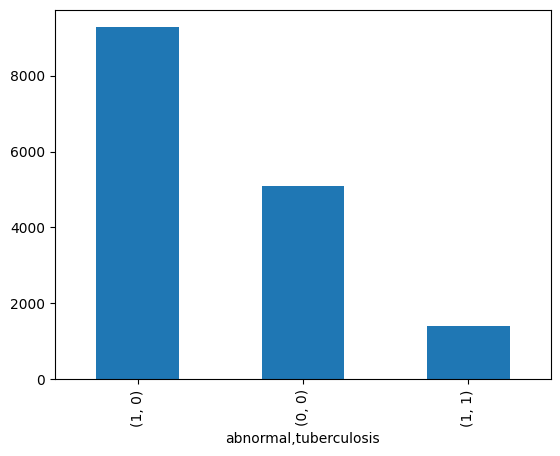

In [8]:
data_distribution.plot(kind='bar')

In [9]:
##Initialize Dataset
imgs_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])
tb_dataset = TuberculosisDataset(dataframe=tb_df, transforms=imgs_transforms)

train_loader = DataLoader(tb_dataset, batch_size=BATCH_SIZE, shuffle=True)

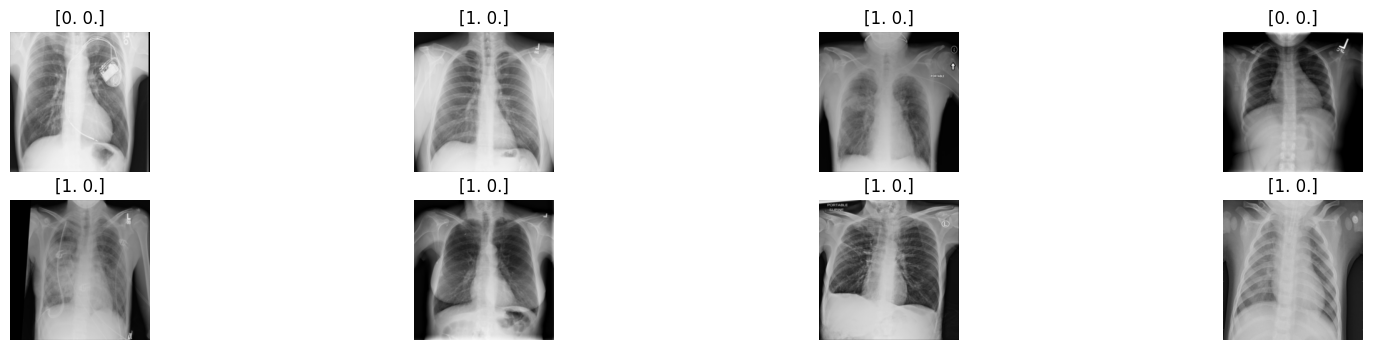

In [10]:
images, labels = next(iter(train_loader))
images = [np.transpose(img.numpy(), (1, 2, 0)) for img in images]
labels = labels.numpy()

show_images(images, labels)

In [11]:
## Define the model

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
if FREEZE_FEATURES:
    for param in model.features.parameters():
        param.requires_grad = False

model.classifier = VGG16DoubleHeadClassifier()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
criterion = get_2heads_criterion(nn.BCELoss())
if FREEZE_FEATURES:
    optimizer = optim.SGD(model.classifier.parameters(), lr=LR, momentum=0.9)
else:
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

In [ ]:
model, losses = train_model(model = model,
    train_loader = train_loader,
    optimizer = optimizer,
    criterion = criterion,
    epochs = EPOCHS,
    # val_loader,
    device=device,
    save_folder="./modelspth",
    save_best=True)